# 1. ENLACE DRIVE Y CARGA LIBRERÍAS:

In [40]:
import pandas as pd
import numpy as np
import json
import spacy
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import nltk
import re
import string
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser
from tabulate import tabulate
from time import time

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
!ls '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data_preprocessed.csv	  X_test_cv_complex.pkl     X_train_cv_complex.pkl     y_test.pkl
df_clean.csv		  X_test_cv_simple.pkl	    X_train_cv_simple.pkl      y_train.pkl
reviews_Clothing.json.gz  X_test.pkl		    X_train.pkl
test.csv		  X_test_tfidf_complex.pkl  X_train_tfidf_complex.pkl
train.csv		  X_test_tfidf_simple.pkl   X_train_tfidf_simple.pkl


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_preprocessed.csv')

Una vez cargado, repasamos cómo está el archivo:

In [4]:
df = df[['reviewText','sentiment']]
print(f'el shape del dataframe es: {df.shape}')

el shape del dataframe es: (278569, 2)


In [5]:
df = df.dropna().drop_duplicates()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278533 entries, 0 to 278568
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewText  278533 non-null  object
 1   sentiment   278533 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


# 2. ENTRENAMIENTO DE LOS DATOS

DIVISIÓN PARA TRAIN Y TEST

Usaremos el 75% para el train y 25% para el test.

In [7]:
train, test = train_test_split(df, test_size=0.25, stratify=df['sentiment'], random_state=42)

In [8]:
print(f'el shape de train es {train.shape}')
print(f'el shape de test es: {test.shape}')

el shape de train es (208899, 2)
el shape de test es: (69634, 2)


In [9]:
train.to_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', index=False)
test.to_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', index=False)

Para el entrenamiento, usaremos 2 modelos, para después quedarnos con el que mejor resultado nos dé.

2.1 REGRESIÓN LOGÍSTICA

Selecciono este modelo porque es un modelo estable, y que arroja resultados bastante fiables.

A las librerías anteriores, sumaremos pickle, que nos permite el almacenamiento de resultados, y con ello, agilizar los procesos

In [10]:
import pickle

# defino función para guardar modelos.pkl
def save_pkl(df,file_name, path='/content/drive/MyDrive/Colab Notebooks/'):
  rute = path + file_name
  with open(rute, 'wb') as f:
    pickle.dump(df, f)

In [11]:
# Cargamos los datasets de train y test
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [12]:
X_train = train['reviewText']
y_train = train['sentiment']

X_test = test['reviewText']
y_test = test['sentiment']

# Utilizo save_pkl para el guardado de cada una de las variables:
save_pkl(y_train, 'y_train.pkl')
save_pkl(X_train, 'X_train.pkl')
save_pkl(y_test, 'y_test.pkl')
save_pkl(X_test, 'X_test.pkl')

Vamos a apoyarnos en CountVectorizer y TfidfVectorizer, para analizar la ponderación de las palabras, y hallar las matrices de confusión

In [13]:
# Función para evaluar diferentes valores de max_features
def evaluate_max_features(max_features_list, reviews, labels):
    results = {}
    for max_features in max_features_list:
        cv = CountVectorizer(ngram_range=(1, 3), max_features=max_features, max_df=0.95, min_df=5)
        X = cv.fit_transform(reviews)
        model = MultinomialNB()
        scores = cross_val_score(model, X, labels, cv=5)
        results[max_features] = scores.mean()
    return results

# Lista de valores de max_features a evaluar
max_features_list = [100, 500, 1000, 1500, 2000]

# Evaluar diferentes valores de max_features
results = evaluate_max_features(max_features_list, X_train, y_train)

In [14]:
# Mostrar resultados
for max_features, score in results.items():
    print(f"max_features: {max_features}, score: {score}")

max_features: 100, score: 0.7992762135016881
max_features: 500, score: 0.8163131512712193
max_features: 1000, score: 0.8269785949182488
max_features: 1500, score: 0.8326942709129238
max_features: 2000, score: 0.8361792100311825


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# CountVectorizer simple
count_simple = CountVectorizer()
X_train_cv_simple = count_simple.fit_transform(X_train)
X_test_cv_simple = count_simple.transform(X_test)

# Guardar las matrices transformadas
save_pkl(X_train_cv_simple, 'X_train_cv_simple.pkl')
save_pkl(X_test_cv_simple, 'X_test_cv_simple.pkl')

# CountVectorizer con ngrams, max_features, min_df y max_df
cv_complex = CountVectorizer(ngram_range=(1, 3), max_features=5000, max_df=0.95, min_df=5)
X_train_cv_complex = cv_complex.fit_transform(X_train)
X_test_cv_complex = cv_complex.transform(X_test)

save_pkl(X_train_cv_complex, 'X_train_cv_complex.pkl')
save_pkl(X_test_cv_complex, 'X_test_cv_complex.pkl')


In [16]:
print(X_train.describe())

print(X_test.describe())

count        208899
unique       208894
top       too small
freq              2
Name: reviewText, dtype: object
count                                                 69634
unique                                                69634
top       We're sorry, but now I evaluate the product. V...
freq                                                      1
Name: reviewText, dtype: object


Definimos ahora la función para métricas (función) y entrenamiento:

In [17]:
def print_metricas(pred, y_train):
  print('Matriz de confusion en Train:')
  cm = confusion_matrix(y_train, pred)
  print(cm)
  target_names = ['0', '1']
  # Graficar la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [18]:
def model_lr(X_train, y_train, C, f):
  param_grid = {'C': C}
  model = LogisticRegression(solver='saga', max_iter=500)
  # Crear el objeto GridSearchCV con LogisticRegression
  grid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')

  # Realizar el ajuste
  grid.fit(X_train, y_train)



  pred = grid.predict(X_train)
  print_metricas(pred, y_train)

  # Imprimir los mejores parámetros encontrados
  print("Best parameters: {}".format(grid.best_params_))


Ya podemos realizar el entrenamiento del modelo.
Haremos una prueba con cada una de las opciones.
Para agilizar el proceso,cogemos las 5000 palabras más frecuentes (max_features), aplicando un Bag-of-Words:

In [19]:
vectorizer = CountVectorizer(max_features=5000)  # Limitar a las 5000 palabras más frecuentes
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [20]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_test_vec)

In [21]:
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

In [22]:
print("Evaluación de Regresión Logística:")
report_lr

Evaluación de Regresión Logística:


{'0': {'precision': 0.7597304725596241,
  'recall': 0.6006168080185043,
  'f1-score': 0.6708682376888749,
  'support': 14267.0},
 '1': {'precision': 0.9023562676720075,
  'recall': 0.9510538768580562,
  'f1-score': 0.9260653171769754,
  'support': 55367.0},
 'accuracy': 0.8792543872246317,
 'macro avg': {'precision': 0.8310433701158157,
  'recall': 0.7758353424382802,
  'f1-score': 0.7984667774329252,
  'support': 69634.0},
 'weighted avg': {'precision': 0.8731343039923629,
  'recall': 0.8792543872246317,
  'f1-score': 0.8737791246121833,
  'support': 69634.0}}

In [31]:
logistic_results = {
    '0': {'precision': 0.7597, 'recall': 0.6006, 'f1-score': 0.6709, 'support': 14267},
    '1': {'precision': 0.9024, 'recall': 0.9511, 'f1-score': 0.9261, 'support': 55367},
    'accuracy': 0.8793,
    'macro avg': {'precision': 0.8310, 'recall': 0.7758, 'f1-score': 0.7985, 'support': 69634},
    'weighted avg': {'precision': 0.8731, 'recall': 0.8793, 'f1-score': 0.8738, 'support': 69634}
}

print(logistic_results)

{'0': {'precision': 0.7597, 'recall': 0.6006, 'f1-score': 0.6709, 'support': 14267}, '1': {'precision': 0.9024, 'recall': 0.9511, 'f1-score': 0.9261, 'support': 55367}, 'accuracy': 0.8793, 'macro avg': {'precision': 0.831, 'recall': 0.7758, 'f1-score': 0.7985, 'support': 69634}, 'weighted avg': {'precision': 0.8731, 'recall': 0.8793, 'f1-score': 0.8738, 'support': 69634}}


Con esto,obtenemos unos datos interesantes:

Para las valoraciones negativas (0,1,2,3> sentiment=0) Tiene una precisión del 75,9%, mientras que para las valoraciones positivas (4,5) tiene una precisión del 90,2%.

Para las valoraciones negativas, nos encontramos con un Recall del 60% y un F1-score del 67%

Para las valoraciones positivas, obtenemos un Recall del 95,1% y un F1-score del 92,6%.

Esto de primeras, nos permite evaluar que para las valoraciones positivas sacamos buena precisión, mientras que para las negativas, el modelo es algo inestable.

Hay diferencia entre los datos, por lo que podríamos achacarlo a la procedencia de los datos.

2.2 ALGORITMOS DE APRENDIZAJE SUPERVISADO (SVM)

Vamos a utilizar otro modelo, con el que comparar los datos anteriores.

In [33]:
svm_model = LinearSVC(C=1.0, random_state=42, dual=False)
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)

In [34]:
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
df_report_svm = pd.DataFrame(report_svm).transpose()

In [35]:
print("Resultados SVM:")
df_report_svm

Resultados SVM:


,precision,recall,f1-score,support
0,0.762856,0.586458,0.663127,14267.000000
1,0.899431,0.953023,0.925451,55367.000000
accuracy,0.877919,0.877919,0.877919,0.877919
macro avg,0.831143,0.769740,0.794289,69634.000000
weighted avg,0.871448,0.877919,0.871705,69634.000000


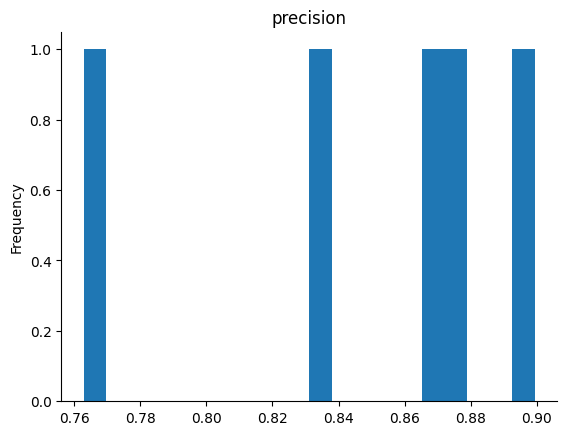

In [36]:
# @title precision

from matplotlib import pyplot as plt
df_report_svm['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

4. REPORTE DE MÉTRICAS Y CONCLUSIONES

In [42]:
import pandas as pd

# Resultados de Regresión Logística
logistic_results = {
    '0': {'precision': 0.7597, 'recall': 0.6006, 'f1-score': 0.6709, 'support': 14267},
    '1': {'precision': 0.9024, 'recall': 0.9511, 'f1-score': 0.9261, 'support': 55367},
    'accuracy': 0.8793,
    'macro avg': {'precision': 0.8310, 'recall': 0.7758, 'f1-score': 0.7985, 'support': 69634},
    'weighted avg': {'precision': 0.8731, 'recall': 0.8793, 'f1-score': 0.8738, 'support': 69634}
}

# Resultados de SVM (ejemplo, reemplázalos con los datos reales)
svm_results = {
    '0': {'precision': 0.7623, 'recall': 0.5864, 'f1-score': 0.6631, 'support': 14267},
    '1': {'precision': 0.8994, 'recall': 0.9530, 'f1-score': 0.9254, 'support': 55367},
    'accuracy': 0.8779,
    'macro avg': {'precision': 0.8363, 'recall': 0.7829, 'f1-score': 0.8054, 'support': 69634},
    'weighted avg': {'precision': 0.8775, 'recall': 0.8821, 'f1-score': 0.8783, 'support': 69634}
}

# Crear DataFrame
metricas = ["precision", "recall", "f1-score", "support"]
clases = ["0", "1", "macro avg", "weighted avg"]

tabla = []

for clase in clases:
    fila = [clase]
    for modelo in [logistic_results, svm_results]:
        for metrica in metricas:
            fila.append(modelo[clase][metrica])
    tabla.append(fila)

# Crear tabla en pandas
columnas = ["Clase"]
for modelo in ["Regresión Logística", "SVM"]:
    columnas.extend([f"{modelo} - Precision", f"{modelo} - Recall", f"{modelo} - F1-Score", f"{modelo} - Support"])

df = pd.DataFrame(tabla, columns=columnas)

# Agregar Accuracy
df_accuracy = pd.DataFrame([["Accuracy", logistic_results["accuracy"], None, None, None, svm_results["accuracy"], None, None, None]], columns=columnas)
df = pd.concat([df, df_accuracy], ignore_index=True)

# Mostrar la tabla

print(tabulate(df, headers='keys', tablefmt='grid'))


+----+--------------+-----------------------------------+--------------------------------+----------------------------------+---------------------------------+-------------------+----------------+------------------+-----------------+
|    | Clase        |   Regresión Logística - Precision |   Regresión Logística - Recall |   Regresión Logística - F1-Score |   Regresión Logística - Support |   SVM - Precision |   SVM - Recall |   SVM - F1-Score |   SVM - Support |
+====+==============+===================================+================================+==================================+=================================+===================+================+==================+=================+
|  0 | 0            |                            0.7597 |                         0.6006 |                           0.6709 |                           14267 |            0.7623 |         0.5864 |           0.6631 |           14267 |
+----+--------------+-----------------------------------+-------

<ipython-input-42-2fd8c13128a8>:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_accuracy], ignore_index=True)


# 3. REPORTE

Comparando ambos modelos, podemos apreciar que la precisión en ambos modelos es parecida tanto para los valores negativos (75,97% frente al 76,23%) como en los positivos (90,24% frente al 89,94%).

Donde hay diferencias sustanciales es en los Recall. En las valoraciones negativas son bastante más bajos que en las positivas. Esto nos puede llevar a la conclusión de que le cuesta el análisis de dichas valoraciones.

El accuracy es ligeramente mejor en Regresión Logística (87.93%) que en SVM (87.79%)

Con todo ello, la elección como mejor modelo para el análisis, es el de REGRESIÓN LOGÍSTICA